# Appendix A

In this work, we reproduce the sample code created for the explanation of how to code an ANN

## General Imports

In [1]:
# Libraries needed to import for this example

import numpy as np                    # Basic numerical python library
import matplotlib.pyplot as plt       # Plotting library for python

import tensorflow as tf               # Google library for Deep Learning
import keras as kr                    # High-level API for Tensorflow

import torch                          # Pytorch library for Deep Learning
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

2024-10-02 13:00:24.332437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Target function

We will use the following function: sin(x$^2$-y$^2$)

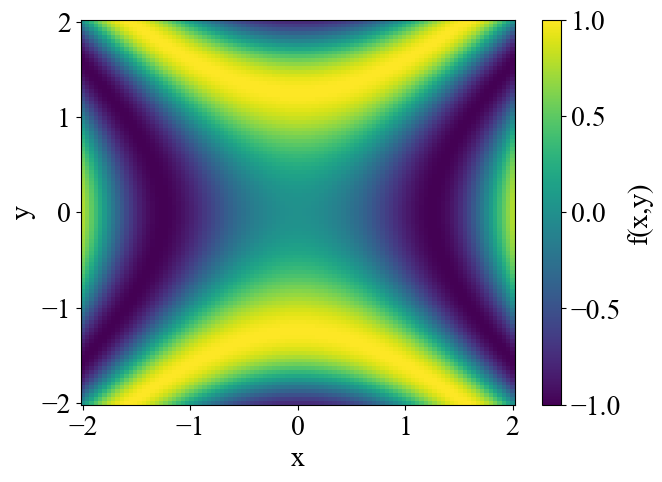

In [2]:
# Step 1: make a 2D mesh to plot it

N_points_plot = 100 # Number of points for each side in the mesh

x_mesh_plot = np.linspace(-2,2,N_points_plot)
y_mesh_plot = np.linspace(-2,2,N_points_plot)

plot_mesh = np.zeros((N_points_plot,N_points_plot))

# Step 2: obtain the function

for i in range(N_points_plot):
    
    for j in range(N_points_plot):
        
        plot_mesh[i,j] = np.sin(x_mesh_plot[i]**2-y_mesh_plot[j]**2)

# Step 3: plot the function

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
pcm = axs.pcolormesh(x_mesh_plot,y_mesh_plot,plot_mesh,clim=(-1,1))
axs.set_ylabel('y', fontsize = 20)
axs.set_xlabel('x', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
cbar = fig.colorbar(pcm)
cbar.ax.set_ylabel('f(x,y)', fontsize = 20)
cbar.ax.tick_params(labelsize = 20)
#fig.savefig('DL_simple_2Dfunct.png', format='png', dpi=600)
plt.show()

## Coding from the beginning

/tmp/ipykernel_12733/704952877.py:23: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  input_data[i*N_points_data+j] = x_mesh_data[i],y_mesh_data[j]


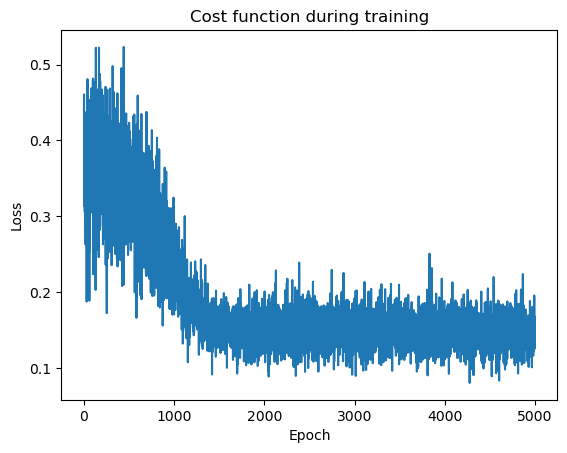

In [22]:
# We will make a network that maps 2 inputs (x,y) to 1 output (sin(x^2-y^2))

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

# Step 1: obtain datasets

N_points_data = 100

x_mesh_data = np.reshape(np.linspace(-2,2,N_points_data),(N_points_data,1))
y_mesh_data = np.reshape(np.linspace(-2,2,N_points_data),(N_points_data,1))

input_data = np.zeros((N_points_data**2,2))
output_data = np.zeros((N_points_data**2,1))

input_data_rand = np.zeros((N_points_data**2,2))
output_data_rand = np.zeros((N_points_data**2,1))

for i in range(N_points_data):
    
    for j in range(N_points_data):
        
        input_data[i*N_points_data+j] = x_mesh_data[i],y_mesh_data[j]
        output_data[i*N_points_data+j] = np.sin(x_mesh_data[i]**2-y_mesh_data[j]**2)
        
random_index = np.linspace(0,N_points_data**2-1,N_points_data**2)
np.random.shuffle(random_index)

for i in range(N_points_data):
    
    for j in range(N_points_data):
        
        index_rand = int(random_index[i*N_points_data+j])
        
        input_data_rand[i*N_points_data+j] = input_data[index_rand]
        output_data_rand[i*N_points_data+j] = output_data[index_rand]
        
# Step 2: Create the network piece by piece

# 1) Function to obtain both the activation and its derivative

def net_f_df(z):
    
    val=1/(1+np.exp(-z))
    
    return(val,np.exp(-z)*(val**2))

# 2) Function to perform the operation of a layer

def forward_step(y,w,b): 
    
    z=np.dot(y,w)+b # w=weight matrix, b=bias vector 
    
    return(net_f_df(z)) # apply activation function

# 3) Function to perform a single forward step

def apply_net(y_in):
    
    global Weights, Biases, NumLayers
    global y_layer, df_layer # store y-values and df/dz
    
    y=y_in # start with input values
    y_layer[0]=y
    
    for j in range(NumLayers): # loop through all layers, j=0 first layer above input
        
        y,df=forward_step(y,Weights[j],Biases[j])
        df_layer[j]=df # store f'(z)
        y_layer[j+1]=y # store f(z)
        
    return(y)
    
# 4) Function to perform a sinlge backwards step
    
def backward_step(delta,w,df):
    
    # delta at layer N, of batchsize x layersize(N))
    # w [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    
    return(np.dot(delta,np.transpose(w))*df)
    
# 5) Function to perform the full backpropagation

def backprop(y_target):
    
    # the result will be the 'dw_layer' matrices with
    # the derivatives of the cost function with respect to
    # the corresponding weight (similar for biases)
    
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db
    global batchsize
    
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=np.dot(np.transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    
    for j in range(NumLayers-1):
        
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=np.dot(np.transpose(y_layer[-3-j]),delta)/batchsize
        db_layer[-2-j]=delta.sum(0)/batchsize
        
# 6) Function to update the parameters with the obtained gradients

def gradient_step(eta): 
    
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]
        
# 7) Function to perform a single training step 

def train_net(y_in,y_target,eta): 
    
    # y_in is an array of size batchsize x (inputlayer size)
    # y_target is an array of size batchsize x (outputlayer size)
    # eta is the stepsize for the gradient descent
    
    global y_out_result
    
    y_out_result=apply_net(y_in)
    backprop(y_target)
    gradient_step(eta)
    cost=((y_target-y_out_result)**2).sum()/batchsize
    
    return(cost)

# Step 3: train the network

# Define hyperparameters

NumLayers=3 # Hidden layers + output layer

LayerSizes=[2,100,100,1] # neurons for input,hidden 1,hidden 2,...,output

batchsize=32 # Size of each of the batches

eta=0.001 # Learning rate

batches=5000 # Number of batches to train for

# Initialize random weights and biases for all layers (except input of course)

Weights=[np.random.uniform(low=-1,high=+1,size=[LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
Biases=[np.random.uniform(low=-1,high=+1,size=LayerSizes[j+1]) for j in range(NumLayers)]

# Initialize rest of variables

y_layer=[np.zeros([batchsize,LayerSizes[j]]) for j in range(NumLayers+1)]

df_layer=[np.zeros([batchsize,LayerSizes[j+1]]) for j in range(NumLayers)]
dw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]

costs=np.zeros(batches) # array to store the costs

# Function to create new batches

def make_batch():
    
    global batchsize
    
    inputs = np.zeros([batchsize,LayerSizes[0]])
    targets = np.zeros([batchsize,LayerSizes[-1]])
    
    random_index_alt = np.random.randint(low=0,high=batchsize, size=(batchsize,))
    
    for ii in range(batchsize):
        
        inputs[ii,:] = input_data[random_index_alt[ii],:]
        targets[ii,:] = output_data[random_index_alt[ii],:]
    
    return (inputs,targets)

# Training loop

for k in range(batches):
    
    y_in,y_target=make_batch()
    
    costs[k]=train_net(y_in,y_target,eta)
    
# Step 4: Plot evolution of cost function

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(costs)
axs.set_xlabel("Epoch", fontsize = 20)
axs.set_ylabel("Loss", fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
#fig.savefig('Traning_appendix1_from0.png', format='png', dpi=600)
plt.show()

## Coding using Keras & Tensorflow

/tmp/ipykernel_7397/144406109.py:23: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  input_data[i*N_points_data+j] = x_mesh_data[i],y_mesh_data[j]
2024-06-25 11:30:26.965270: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


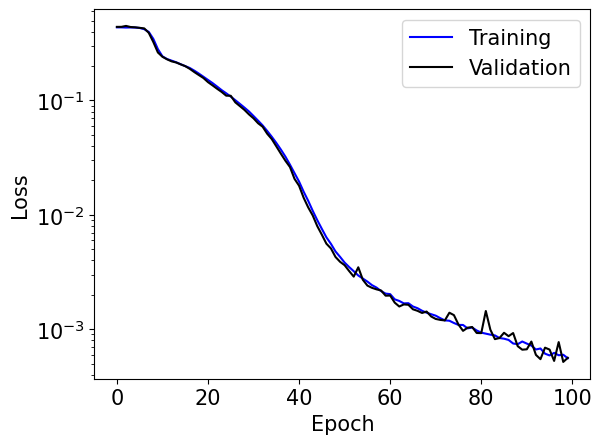

In [3]:
# We will make a network that maps 2 inputs (x,y) to 1 output (sin(x^2-y^2))

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

# Step 1: obtain datasets

N_points_data = 100

x_mesh_data = np.reshape(np.linspace(-2,2,N_points_data),(N_points_data,1))
y_mesh_data = np.reshape(np.linspace(-2,2,N_points_data),(N_points_data,1))

input_data = np.zeros((N_points_data**2,2))
output_data = np.zeros((N_points_data**2,1))

input_data_rand = np.zeros((N_points_data**2,2))
output_data_rand = np.zeros((N_points_data**2,1))

for i in range(N_points_data):
    
    for j in range(N_points_data):
        
        input_data[i*N_points_data+j] = x_mesh_data[i],y_mesh_data[j]
        output_data[i*N_points_data+j] = np.sin(x_mesh_data[i]**2-y_mesh_data[j]**2)
        
random_index = np.linspace(0,N_points_data**2-1,N_points_data**2)
np.random.shuffle(random_index)

for i in range(N_points_data):
    
    for j in range(N_points_data):
        
        index_rand = int(random_index[i*N_points_data+j])
        
        input_data_rand[i*N_points_data+j] = input_data[index_rand]
        output_data_rand[i*N_points_data+j] = output_data[index_rand]

# Step 2: create the network

input_label = kr.Input((2,))
netl = kr.layers.Dense(50, activation = 'sigmoid')(input_label)
netl = kr.layers.Dense(50, activation = 'sigmoid')(netl)
netl = kr.layers.Dense(1)(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 32
n_epochs = 100
val_percentage = 0.2

net2 = net.fit(input_data_rand,output_data_rand,batch_size=batch_size, validation_split=val_percentage, epochs=n_epochs, verbose=0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot the result

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
#fig.savefig('Traning_appendix1_Keras.png', format='png', dpi=600)
plt.show()

## Coding using Pytorch

/tmp/ipykernel_7397/1679162642.py:23: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  input_data[i*N_points_data+j] = x_mesh_data[i],y_mesh_data[j]


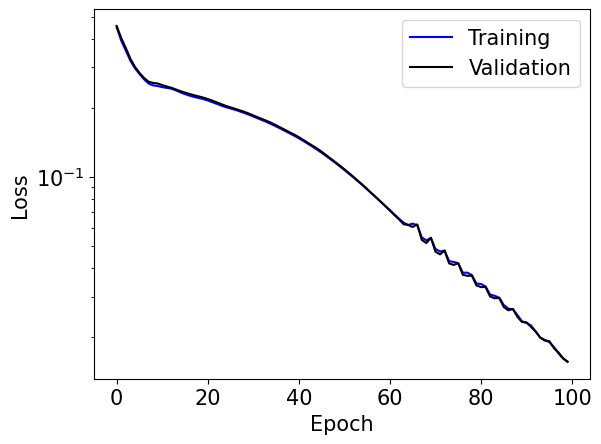

In [57]:
# We will make a network that maps 2 inputs (x,y) to 1 output (sin(x^2-y^2))

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

# Step 1: obtain datasets

N_points_data = 100

x_mesh_data = np.reshape(np.linspace(-2,2,N_points_data),(N_points_data,1))
y_mesh_data = np.reshape(np.linspace(-2,2,N_points_data),(N_points_data,1))

input_data = np.zeros((N_points_data**2,2))
output_data = np.zeros((N_points_data**2,1))

input_data_rand = np.zeros((N_points_data**2,2))
output_data_rand = np.zeros((N_points_data**2,1))

for i in range(N_points_data):
    
    for j in range(N_points_data):
        
        input_data[i*N_points_data+j] = x_mesh_data[i],y_mesh_data[j]
        output_data[i*N_points_data+j] = np.sin(x_mesh_data[i]**2-y_mesh_data[j]**2)
        
random_index = np.linspace(0,N_points_data**2-1,N_points_data**2)
np.random.shuffle(random_index)

for i in range(N_points_data):
    
    for j in range(N_points_data):
        
        index_rand = int(random_index[i*N_points_data+j])
        
        input_data_rand[i*N_points_data+j] = input_data[index_rand]
        output_data_rand[i*N_points_data+j] = output_data[index_rand]

# Step 2: create the network

in_dim = 2
out_dim = 1
n_neurons = 100

learning_rate = 0.003

# Create a list of all the layers

layers = [nn.Linear(in_dim, n_neurons), nn.ReLU(), nn.Linear(n_neurons, n_neurons), nn.ReLU(), nn.Linear(n_neurons,out_dim)]

net = nn.Sequential(*layers) # Create the full network

# Create optimizer

opt = optim.Adam(net.parameters(), learning_rate)

# Create Loss

losss = nn.MSELoss()

# Step 3: train the network

train_costs = [] # List to hold the evolution of the training loss
val_costs = [] # List to hold the evolution of the validation loss

n_epochs = 100
val_percentage = 0.2
batch_size = int((1-val_percentage)*input_data.shape[0])

def make_batch(size,train_set_in,train_set_out):
    
    batch_in = []
    batch_out = []
    
    random_index_alt = np.random.randint(low=0,high=train_set_in.shape[0], size=(train_set_in.shape[0],))
    
    for ii in range(size):
        
        batch_in.append(train_set_in[ii,:])
        batch_out.append(train_set_out[ii,:])
        
    return (batch_in,batch_out)

train_index = np.linspace(0,int((1-val_percentage)*input_data.shape[0]-1),int((1-val_percentage)*input_data.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*input_data.shape[0]),input_data.shape[0]-1,int(val_percentage*input_data.shape[0])).astype(int)

input_rand_train = input_data_rand[train_index,:]
input_rand_val = input_data_rand[val_index,:]

target_rand_train = output_data_rand[train_index,:]
target_rand_val = output_data_rand[val_index,:]

for i in range(n_epochs):
    
    in_batch,target_batch = make_batch(batch_size,input_rand_train,target_rand_train)
    
    repro_batch_train = []
    repro_batch_val = []
    
    for i in range(batch_size):
        
        repro_batch_train.append(net.forward(torch.from_numpy(in_batch[i]).float()))
        
    for j in range(input_rand_val.shape[0]):
        
        repro_batch_val.append(net.forward(torch.from_numpy(input_rand_val[j]).float()))
        
    train_loss = losss(torch.tensor(target_batch).float(),torch.stack(repro_batch_train).float())
    val_loss = losss(torch.from_numpy(target_rand_val).float(),torch.stack(repro_batch_val).float())
    
    #print(train_loss.item())
    
    train_costs.append(train_loss.item())
    val_costs.append(val_loss.item())
    
    opt.zero_grad() # Reset the gradients
    train_loss.backward() # backpropagation
    opt.step() # gradient descent
    
# Step 4: plot the result

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(train_costs,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
#fig.savefig('Traning_appendix1_Pytorch.png', format='png', dpi=600)
plt.show()